# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

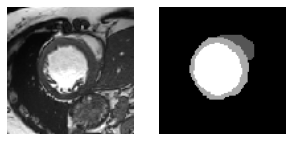

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr3.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr3_mask.png'), cv2.IMREAD_UNCHANGED)


show_image_mask(image, mask, cmap='gray')
plt.pause(1)
# cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

# Introduction


## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [149]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.img_files.sort() # sort the files with names
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
        # get the path of these images  

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float(), img_path 
            #also return the image name
            #change it from numpy to tesnor

    def __len__(self):
        return len(self.img_files)
        # how many train images

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.img_files.sort()

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), img_path

    def __len__(self):
        return len(self.img_files)

### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module): #convlution 2 times in this layer


    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels), 
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # pooling the figure make the size smaller
            DoubleConv(in_channels, out_channels) # convlution 2 times
        ) 

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):


    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # double the figure size
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2) #convolution the image 2 times, and make channels larger

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # copy and crop from the corresponding down layer

        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) 
        # make the output channel become the specific channel

    def forward(self, x):
        return self.conv(x)

In [277]:
#UNet model
# shape 128
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNSEG(nn.Module):  # Define your model
    def __init__(self, n_channels, n_classes):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here

        self.n_channels = n_channels # define input channel
        self.n_classes = n_classes   # define output channel
        
        # change the channel but keep the same figure size
        self.inc = DoubleConv(n_channels, 8) # 96*96*1 --> 96*96*8
        
        #decoder: in every function, convlove 2 times, change the channel and the figure size
        self.down1 = Down(8, 32) # 96*96*8 --> 48*48*32
        self.down2 = Down(32, 64) # 48*48*32 --> 24*24*64
        self.down3 = Down(64, 128) # 24*24*64 --> 12*12*128
        # keep the same channel, change the figure size
        self.down4 = Down(128, 128) # 12*12*128 --> 6*6*128
        
        self.up1 = Up(256, 64) # 6*6*128 --> 12*12*64
        self.up2 = Up(128, 32) # 12*12*64 --> 24*24*32
        self.up3 = Up(64, 8)   # 48*48*32 --> 96*96*8
        self.up4 = Up(16, 8)   #96*96*8 --> 96*96*8

        self.outc = OutConv(8, n_classes) # 96*96*8 --> 96*96*4

    def forward(self, x):
        x1 = self.inc(x)

        x2 = self.down1(x1)

        x3 = self.down2(x2)

        x4 = self.down3(x3)

        x5 = self.down4(x4)

        x = self.up1(x5, x4)

        x = self.up2(x, x3)

        x = self.up3(x, x2)

        x = self.up4(x, x1)

        logits = self.outc(x)

        return logits


model = CNNSEG(1, 4)  # We can now create a model using your defined segmentation model

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

# Loss Function (focal, dice loss)

In [ ]:
#dice_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class DiceLoss(nn.Module):
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        if weight is not None:
            weight = torch.Tensor(weight)
            self.weight = weight / torch.sum(weight) # Normalized weight
        self.smooth = 1e-5

    def forward(self, predict, target):
        N, C = predict.size()[:2]
        predict = predict.view(N, C, -1) 
        target = target.view(N, 1, -1) 

        predict = F.softmax(predict, dim=1) 
        
        target_onehot = torch.zeros(predict.size())  
        target_onehot.scatter_(1, target, 1)  

        intersection = torch.sum(predict * target_onehot, dim=2) 
        union = torch.sum(predict.pow(2), dim=2) + torch.sum(target_onehot, dim=2) 
        
        dice_coef = (2 * intersection + self.smooth) / (union + self.smooth)  

        if hasattr(self, 'weight'):
            if self.weight.type() != predict.type():
                self.weight = self.weight.type_as(predict)
                dice_coef = dice_coef * self.weight * C  
        dice_loss = 1 - torch.mean(dice_coef)  

        return dice_loss
    
# criterion = DiceLoss(weight=[1, 1])
# loss = criterion(y_predict, y_target)

In [ ]:
#focal loss

from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLoss(nn.Module):

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):

        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
     
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
    
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return 0.
        x = x[unignored_mask]


        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:

    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

# Loss = FocalLoss()

# Setting of learning rate, optimizer and loss function

In [278]:
learning_rate = 0.001

Loss = nn.CrossEntropyLoss()
# Losss = SoftDiceLossV1()
# Loss = FocalLoss(gamma=0, alpha=1)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate,  weight_decay=1e-8, momentum=0.9)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.005)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [279]:
from torch.utils.data import DataLoader
import time

data_path = './data/train'
path = './data/Seg_8_256_Adam_0.001_50.pt'
num_workers = 4
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
num_epochs = 50
# Fetch images and labels. 

start = time.time()
for epoch in range(num_epochs):
    print(epoch)
    model.train()
    for iteration, sample in enumerate(training_data_loader):
        
        img, mask, name = sample
        img1 = img.unsqueeze(1)

        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
    

 
        y_predict = model.forward(img1)
        mask = mask.type(torch.long)
        loss = Loss(y_predict, mask)


    
        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
       
        
    if epoch in record: 
        finish = time.time()
        train_time = finish - start
        print(train_time)
        torch.save(model.state_dict(), './data/unet_{}.pt'.format(epoch))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
666.8818581104279


### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

# test 
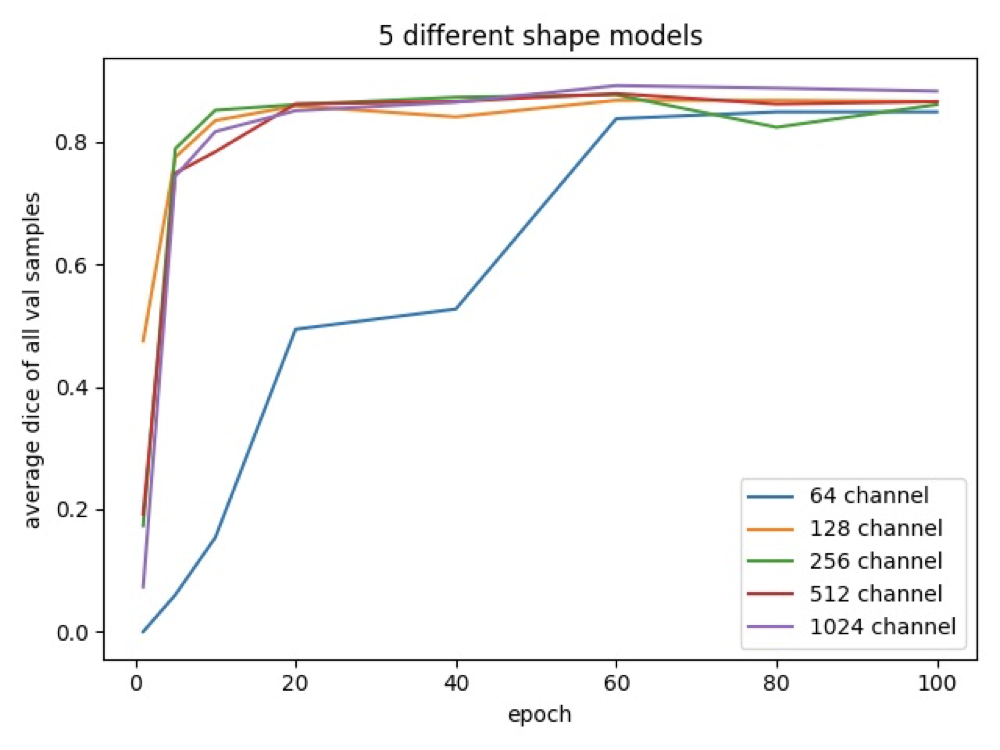

In [280]:
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
path = './data/Seg_8_256_Adam_0.001_50.pt'

# generate test samples' predict figures

In [281]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
from torchvision.utils import save_image

test_path = './data/test'
num_workers = 4
batch_size = 2

test_set = TestDataset(test_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers, batch_size = batch_size, shuffle=False)
test_no= 121

model.load_state_dict(torch.load(path))
model.eval()
for sample, name in test_data_loader:

    img = sample.unsqueeze(1)

    x = model.forward(img)
    
    for i in range(batch_size):
        predict_mask = torch.argmax(x[i].squeeze(), dim=0).detach().numpy()
        cv2.imwrite('./data/val/mask/cmr{}_mask.png'.format(test_no), predict_mask)
        test_no +=1

# generate validation set's predict figures

In [283]:
# val

val_path = './data/val'

num_workers = 4
batch_size = 2

val_set = TrainDataset(val_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

picture_no= 101

model.load_state_dict(torch.load(path))
model.eval()
for iteration, sample in enumerate(val_data_loader):
    
    img, mask, name = sample
    img2 = img.unsqueeze(1)

    x = model.forward(img2) 
    
    
    for i in range(batch_size):
        predict_mask = torch.argmax(x[i].squeeze(), dim=0).detach().numpy()
        cv2.imwrite('./data/val/mask2/cmr{}_mask.png'.format(picture_no), predict_mask)
        picture_no +=1

    

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [284]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

# the average dice score of val set

In [286]:
data_dir = './data/val'

label_class = 2
true_mask = []
predict_mask = []

for i in range(101, 121):
    mask1 = cv2.imread(os.path.join(data_dir,'mask','cmr{}_mask.png'.format(i)), cv2.IMREAD_UNCHANGED)
    mask2 = cv2.imread(os.path.join(data_dir,'mask2','cmr{}_mask.png'.format(i)), cv2.IMREAD_UNCHANGED)
    true_mask.append(mask1)
    predict_mask.append(mask2)

sum_val = 0
for i in range(len(true_mask)):

    summary = 0
    labe_class = 1
    for j in range(3):
        x = categorical_dice(true_mask[i], predict_mask[i], labe_class)
        summary +=x
        labe_class +=1
    average = summary/3
    sum_val +=average
print("average dice of val samples:")
print(sum_val/len(true_mask))

0.4008928131564395
0.25856125049067163
0.8130854199568965
0.7984025997435062
0.793528294591825
0.6128940755878678


### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [220]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)



    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        
        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)


        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

# generate CSV file for kaggle

In [221]:
submission_converter("/Users/nolan/CW2/data/test/mask", "/Users/nolan/CW2/data/test/submission")